## CNN в качестве энкодера, декодер из трансформера и улучшенные техники обучения

Работа вдохновлена туториалами [bentrevett](https://github.com/bentrevett) по Seq2Seq [5](https://github.com/bentrevett/pytorch-seq2seq/blob/master/5%20-%20Convolutional%20Sequence%20to%20Sequence%20Learning.ipynb) и [6](https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb), а также туторилами по Image Classification [3](https://github.com/bentrevett/pytorch-image-classification/blob/master/3_alexnet.ipynb) и [5](https://github.com/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb). Основной идеей этого подхода была апробация комбинации нескольких разных архитектур и техник. Работа носит якро выраженный экспериментальный характер.

**Описание подхода.**

1. Подготовка данных принципиально не отличается от baseline ноутбука.
2. Модель является симбиозом CNN-энкодера и Transformer-декодера:
  - За основу экнодера взят код [отсюда](https://github.com/bentrevett/pytorch-seq2seq/blob/master/5%20-%20Convolutional%20Sequence%20to%20Sequence%20Learning.ipynb). К нему были добавлены
    - Inception-блоки, одновременно сворачивающие последовательность как фильтром размера 3, так и фильтром размера 5.
    - Skip-connection'ы через каждые 2 блока, аналогичные применяемым в архитектуре ResNet'а.
    - Реализован Batch Norm.
    
    Энкодер возвращает два тензора: conved и combined. Первый является выходным результатом всех сверточных слоев сети, второй — сумма conved с эмбеддингом соответствующего слова. Combined несет больше локальной информации, а conved — интегральной обо всей последовательности.

 - Декодер, в целом, повторяет идеи, примененные в подходе с [DistilBert-энкодером](https://colab.research.google.com/drive/1sT5tPaRasXq2M55whxb1hPnz-adBan6e?usp=sharing), которые были, в свою очередь, основаны на [этом туториале](https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb). Однако в качестве эксперимента в self-attention слой декодера, обрабатывающий выход энкодера, теперь подается не одно представление source-предложения, а два: conved и combined. Причем combined подается в самый первый слой декодера и в самый последний, а в остальные приходит conved. Это сделано из предположения, что при обработке первого слоя, агрегирующего более локальную информацию, а также последнего слоя, выход которого непосредственно используется для предсказаний, более важна локальная информация, содержащаяся в combined.

3. Подготовка модели к обучению и выбор гиперпараметров включает в себя комбинацию нескольких техник:
 - Инициализация весов модели происходит по-разному для энкодера и декодера. Последний инициализируется посредством nn.init.xavier_uniform_ для весов. В энкодере свертки инициализируются nn.init.xavier_normal_ c множителем для сигмоиды, а линейные слои — nn.init.kaiming_normal_ для leaky_relu. Bias'ы везде приравниваются 0.
 - Реализован поиск оптимального learning_rate'а, основанный на подходе, продемонстрированном [здесь](https://github.com/bentrevett/pytorch-image-classification/blob/master/3_alexnet.ipynb), который, в свою очередь, вдохновлен идеями [отсюда](https://github.com/davidtvs/pytorch-lr-finder).

4. Обучение также включает в себя несколько моментов, на которые можно обратить внимание:
 - Оптимизатором является AdamW, с разными learning_rate'ами для экнодера и декодера. Несмотря на наличие большого количества skip-connection'ов, для энкодера этот гиперпараметр выбран бОльшим, чем для декодера, что, возможно, дополнительно решает проблему затухающих градиентов. (Энкодер учится с нуля. Иначе было бы наоборот: у декодера learning_rate имело бы смысл делать больше.)
 - После первых 5 эпох активируется изменение leraning_rate'а с использованием [CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR).

5. Оценка результатов перевода и BLEU score аналогична остальным подходам.

### Подготовка данных

In [ ]:
!nvidia-smi

Sun Oct 24 21:42:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import _LRScheduler

from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy
from nltk.tokenize import WordPunctTokenizer

import random
import time
import math

import os
import json

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
--2021-10-24 21:42:43--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.1s    

2021-10-24 21:42:44 (93.5 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

batch_first=True для удобства.

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True,
            batch_first=True)

TRG = Field(tokenize=tokenize,
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True,
            batch_first=True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

print()
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

print()
print("Part of russian vocab:", SRC.vocab.itos[::1000])
print("Part of english vocab:", TRG.vocab.itos[::1000])

print()
print("Example of data:")
print("English (target):", vars(train_data.examples[9])["trg"])
print("Russian (source):", vars(train_data.examples[9])["src"])

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500

Unique tokens in source (ru) vocabulary: 14129
Unique tokens in target (en) vocabulary: 10104

Part of russian vocab: ['<unk>', 'террасу', 'чистые', 'компьютеры', 'don', 'шамони', 'logis', 'форму', 'душевые', 'техасского', 'm7', 'бьерт', 'курантов', 'проведенного', 'шезлонге']
Part of english vocab: ['<unk>', 'springs', 'galeao', 'calm', 'occupies', 'tegel', 'malioboro', 'athena', 'haapsalu', 'perdido', 'wilpattu']

Example of data:
English (target): ['other', 'facilities', 'offered', 'at', 'the', 'property', 'include', 'grocery', 'deliveries', ',', 'laundry', 'and', 'ironing', 'services', '.']
Russian (source): ['также', 'предлагается', 'доставка', 'продуктов', ',', 'услуги', 'прачечной', 'и', 'гладильные', 'услуги', '.']


In [ ]:
max_ru_len = 0
max_en_len = 0
for curr_data in (train_data, valid_data, test_data):
    for example in curr_data.examples:
        curr_ru_len = len(vars(example)["src"])
        if curr_ru_len > max_ru_len:
            max_ru_len = curr_ru_len

        curr_en_len = len(vars(example)["trg"])
        if curr_en_len > max_en_len:
            max_en_len = curr_en_len


print("Max RU sentence length:", max_ru_len)
print("Max EN sentence length:", max_en_len)

Max RU sentence length: 80
Max EN sentence length: 99


In [ ]:
# рабочий девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE, 
    device=device,
    sort_key=_len_sort_key
)

Device: cuda


In [ ]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 128x58 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 128x75 (GPU 0)]
torch.Size([128, 75]) torch.Size([128, 58])


Length distribution in Train data


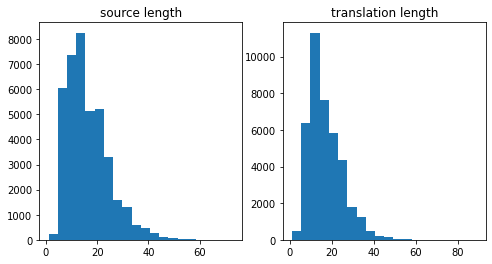

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


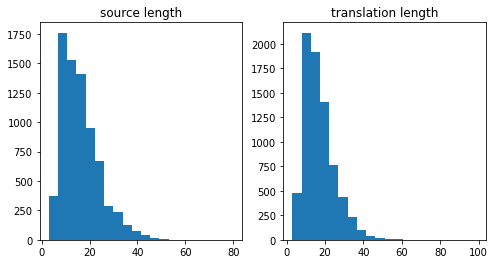

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Модель

Основные изменения касаются экнодера. Декодер и Seq2Seq-модель, в целом, стандартны.

#### Энкодер

Энкодер можно условно поделить на 3 части:
 - Входные эмбеддинги — токенов и позиционные. Далее они суммируются и результат подается в линейный слой, приводящий их к размерности hid_dim.
 - Сверточные слои. Каждый состоит из двух Inception-блоков и skip-connection'а. Более подробно они будут описаны ниже.
 - Выходные слои. Результат последних сверток проходит через линейный слой hid_dim -> emb_dim, порождая conv, после чего складывается с эмбеддингом соответствующего слова, что дает combined.

Conv и combined далее подаются в декодер.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers,
                 dropout, 
                 device,
                 max_length=100):
        super().__init__()
        
        self.device = device
        
        self.emb_scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  dropout, 
                                                  device)
                                    for _ in range(n_layers)])
        
        self.bn_conv_in = nn.BatchNorm1d(hid_dim)
        self.conv_scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)

        self.dropout = nn.Dropout(dropout)

        self.bn_conv_out = nn.BatchNorm1d(emb_dim)
        self.bn_comb_out = nn.BatchNorm1d(emb_dim)
        

    def forward(self, src):
        
        # src = [batch size, src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        # create position tensor
        # pos = [0, 1, 2, 3, ..., src len - 1]
        # pos = [batch size, src len]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        # embed tokens and positions
        # tok_embedded = pos_embedded = [batch size, src len, emb dim]
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        
        # combine embeddings by elementwise summing
        # embedded = [batch size, src len, emb dim]
        embedded = self.dropout((tok_embedded * self.emb_scale) + pos_embedded)
        
        # pass embedded through linear layer to convert from emb dim to hid dim
        # conv = [batch size, src len, hid dim]
        conv = self.emb2hid(embedded)
        
        # permute for convolutional layer and apply Batch Normalization
        # conv = [batch size, hid dim, src len]
        conv = self.bn_conv_in(conv.permute(0, 2, 1))
        
        # begin convolutional blocks...
        for layer in self.layers:
            conv = layer(conv)

        # ...end convolutional blocks

        # permute and convert back to emb dim
        # conv = [batch size, src len, emb dim]
        conv = self.hid2emb(conv.permute(0, 2, 1))

        # elementwise sum output (conved) and input (embedded)
        # combined = [batch size, src len, emb dim]
        combined = (conv + embedded) * self.conv_scale

        conv = self.bn_conv_out(conv.permute(0, 2, 1))
        combined = self.bn_comb_out(combined.permute(0, 2, 1))

        return conv.permute(0, 2, 1), combined.permute(0, 2, 1)

EncoderLayer является кирпичиком центральной части энкодера. Каждый слой состоит из двух Inception-блоков. Вход слоя последовательно подается в каждый блок, а затем следует skip-connection — результат сверток складывется с начальным тензором и к сумме применяется LeakyReLU.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim, 
                 dropout, 
                 device):
        super().__init__()

        self.block_1 = InceptionBlock(hid_dim, dropout, device)
        self.block_2 = InceptionBlock(hid_dim, dropout, device)
        self.bn = nn.BatchNorm1d(hid_dim)
        self.lrelu = nn.LeakyReLU(negative_slope=0.1)

    def forward(self, input):
        # input = [batch size, hid dim, src len]

        # apply convs in InceptionBlocks
        # conved = [batch size, hid dim, src len]
        conved = self.block_1(input)
        conved = self.block_2(conved)

        # skip-connection
        # conved = [batch size, hid dim, src len]
        conved = self.lrelu(conved + input)

        return self.bn(conved)

Inception-блок параллельно применяет к входу свертки с ядром разного размера — 3 и 5. При этом hid_dim увеличивается в 2 раза. Затем к двум результатам применяется [GLU](https://pytorch.org/docs/stable/generated/torch.nn.functional.glu.html), приводя их к прежнему размеру hid_dim, после чего они складываются друг с другом и с входным тензором блока. Таким образом, помимо skip-connection'ов через два блока в слое энкодера, в самих блоках также реализован собственный skip-connection.

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self,
                 hid_dim, 
                 dropout, 
                 device):
        super().__init__()

        self.conv_3 = nn.Conv1d(in_channels=hid_dim,
                                out_channels=2*hid_dim, 
                                kernel_size=3, 
                                padding=1)
        
        self.conv_5 = nn.Conv1d(in_channels=hid_dim,
                                out_channels=2*hid_dim, 
                                kernel_size=5, 
                                padding=2)
        
        self.bn = nn.BatchNorm1d(hid_dim)
        self.scale = torch.sqrt(torch.FloatTensor([0.33])).to(device)
        self.dropout = nn.Dropout(dropout)


    def forward(self, conved):
        # conved = [batch size, hid dim, src len]

        # pass through convolutional layers

        # conved_3 = [batch size, 2 * hid dim, src len]
        conved_3 = self.conv_3(self.dropout(conved))

        # conved_5 = [batch size, 2 * hid dim, src len]
        conved_5 = self.conv_5(self.dropout(conved))

        # pass through GLU activation function

        # conved_3 = [batch size, hid dim, src len]
        conved_3 = F.glu(conved_3, dim=1)

        # conved_5 = [batch size, hid dim, src len]
        conved_5 = F.glu(conved_5, dim=1)

        # sum conv results and apply residual connection with input
        # conved = [batch size, hid dim, src len]
        conved = (conved + conved_3 + conved_5) * self.scale

        return self.bn(conved)

#### Декодер

В целом, повторяется код из [подхода с предобученным DistilBERT](https://colab.research.google.com/drive/1sT5tPaRasXq2M55whxb1hPnz-adBan6e?usp=sharing). Однако здесь на вход encoder_attention подается не одно представление экнодера, как в оригинальном трансформере, а два разных: conved и combined, в зависимости от того, какой это слой декодера.

Combined содержит больше локальной информации, так как является суммой conved с эмбеддингом слова. Первый слой декодера рассматривает попарные взаимодействия слов, что, условно, можно назвать более локальными взаимодействиями, сравнивая их с происходящими в более глубоких слоях декодера. Поэтому сначала в него подается combined. Во втором и далее encoder_attention считается уже на основе conved. Затем, на последнем слое декодера, в него опять подается combined, чтобы дать больше локальной информации для перевода конкретного слова.

In [ ]:
# основной класс, в котором реализуются:
# - эмбеддинги токенов и их позиций в предложении
# - слои декодера, каждый из которых содержит по 2 self-attention'а
# - финальный полносвязный слой, а также dropout
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim,
                 enc_emb_dim,
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length=100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
        self.emb2hid_conv = nn.Linear(enc_emb_dim, hid_dim)
        self.emb2hid_comb = nn.Linear(enc_emb_dim, hid_dim)


    def forward(self, trg, src_conved, src_combined, trg_mask, src_mask):
        
        # trg = [batch size, trg len]
        # src_conved = src_combined = [batch size, src len, enc emb dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]

        # src_conved = src_combined = [batch size, src len, hid dim]
        src_conved = self.emb2hid_conv(src_conved)
        src_combined = self.emb2hid_comb(src_combined)

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        # pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        # trg = [batch size, trg len, hid dim]
        # use src_combined for the 1st and the last layers since this source embedding
        # has more local information,
        # for other layers apply attention over src_conved to concentrate on the
        # whole sentence and gain more integral information
        for idx, layer in enumerate(self.layers):
            if idx == 0 or idx == (len(self.layers) - 1):
                trg = layer(trg, src_combined, trg_mask, src_mask)
            else:
                trg = layer(trg, src_conved, trg_mask, src_mask)
        
        # trg = [batch size, trg len, hid dim]
        
        output = self.fc_out(trg)
        
        # output = [batch size, trg len, output dim]
        
        return output



# класс слоя декодера, внутри которого применяются LayerNorm, self-attention над
# входом декодера и еще один self-attention над выходом энкодера, затем
# FeedForward слой и dropout
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        # trg = [batch size, trg len, hid dim]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]
        
        # self attention
        # _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        _trg = self.self_attention(trg, trg, trg, trg_mask)
        
        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        # trg = [batch size, trg len, hid dim]
            
        # encoder attention
        # _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        _trg = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        # trg = [batch size, trg len, hid dim]
        
        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        # trg = [batch size, trg len, hid dim]
        # attention = [batch size, n heads, trg len, src len]
        
        # return trg, attention
        return trg



# MultiHead self-attention слой
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        

    def forward(self, query, key, value, mask=None):
        
        batch_size = query.shape[0]
        
        # query = [batch size, query len, hid dim]
        # key = [batch size, key len, hid dim]
        # value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        # Q = [batch size, query len, hid dim]
        # K = [batch size, key len, hid dim]
        # V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # Q = [batch size, n heads, query len, head dim]
        # K = [batch size, n heads, key len, head dim]
        # V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        # energy = [batch size, n heads, query len, key len]
        
        # where mask value is 0 put -1e10
        if mask is not None:
            energy = energy.masked_fill(mask==0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        # attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        # x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        # x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        # x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        # x = [batch size, query len, hid dim]
        
        # return x, attention
        return x



# полносвязный слой, применяющийся к выходам self-attention слоев
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, x):
        
        # x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        # x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        # x = [batch size, seq len, hid dim]
        
        return x

#### Seq2Seq

Стандартная Seq2Seq модель, объединяющая энкодер и декодер. Для последнего создаются маски source и target последовательностей, чтобы он не обуславливался на паддинги и не заглядывал в будущее, делая предсказания только на основе предыдущих обработанных слов.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        

    def make_src_mask(self, src):
        
        # src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask = [batch size, 1, 1, src len]

        return src_mask
    

    def make_trg_mask(self, trg):
        
        # trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        # trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        # trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        # trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask


    def forward(self, src, trg):
        
        # src = [batch size, src len]
        # trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        # src_mask = [batch size, 1, 1, src len]
        # trg_mask = [batch size, 1, trg len, trg len]
        
        src_conved, src_combined = self.encoder(src)
        
        # src_conved = src_combined = [batch size, src len, enc emb dim]
                
        output = self.decoder(trg, src_conved, src_combined, trg_mask, src_mask)
        
        # output = [batch size, trg len, output dim]
        
        return output

### Подготовка к обучению

Объявляется модель и вспомогательные функции: train(), evaluate() и т.д. Инициализируются веса и осуществляется подбор гиперпараметров.

#### Объявление модели

Энкодер и декодер.


In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
HID_DIM = 512
ENC_LAYERS = 4 # each layer consists of 2 Inception Blocks
DEC_LAYERS = 4
DEC_HEADS = 8
DEC_PF_DIM = 768
ENC_DROPOUT = 0.33
DEC_DROPOUT = 0.1
ENC_MAX_LENGTH = max_ru_len + 2
DEC_MAX_LENGTH = max_en_len + 2

enc = Encoder(INPUT_DIM,
              ENC_EMB_DIM,
              HID_DIM, 
              ENC_LAYERS,
              ENC_DROPOUT, 
              device,
              ENC_MAX_LENGTH)

dec = Decoder(OUTPUT_DIM,
              ENC_EMB_DIM,
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              DEC_MAX_LENGTH)

Seq2Seq модель.

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters in total')
print(f'The encoder has {count_parameters(model.encoder):,} trainable parameters')
print(f'The decoder has {count_parameters(model.decoder):,} trainable parameters')

The model has 59,725,688 trainable parameters in total
The encoder has 37,486,080 trainable parameters
The decoder has 22,239,608 trainable parameters


In [ ]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(14129, 256)
    (pos_embedding): Embedding(82, 256)
    (emb2hid): Linear(in_features=256, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=256, bias=True)
    (layers): ModuleList(
      (0): EncoderLayer(
        (block_1): InceptionBlock(
          (conv_3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
          (conv_5): Conv1d(512, 1024, kernel_size=(5,), stride=(1,), padding=(2,))
          (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.33, inplace=False)
        )
        (block_2): InceptionBlock(
          (conv_3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
          (conv_5): Conv1d(512, 1024, kernel_size=(5,), stride=(1,), padding=(2,))
          (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.33, inpl

#### Инициализация весов

В Inception-блоке энкодера применяется [GLU](https://pytorch.org/docs/stable/generated/torch.nn.functional.glu.html), в котором исходный тензор разбивается на два, одна из частей проходит через сигмоиду, после чего половины поэлементно перемножаются. В [работе](https://arxiv.org/abs/1612.08083), где был предложен GLU, авторы говорят, что при инициализации пользуются kaiming. Для сверток используется xavier инициализация, с множителем для сигмоиды, а для линейных слоев kaiming для LeakyReLU. Bias'ы инициализируются нулями.

In [ ]:
def initialize_encoder(m_enc):
    if isinstance(m_enc, nn.Conv2d):
        nn.init.xavier_normal_(m_enc.weight.data, gain=nn.init.calculate_gain('sigmoid'))
        nn.init.constant_(m_enc.bias.data, 0)
    elif isinstance(m_enc, nn.Linear):
        nn.init.kaiming_normal_(m_enc.weight.data, a=0.1, nonlinearity='leaky_relu')
        nn.init.constant_(m_enc.bias.data, 0)
    elif hasattr(m_enc, 'weight') and m_enc.weight.dim() > 1:
        nn.init.xavier_uniform_(m_enc.weight.data)
        if hasattr(m_enc, 'bias'):
            nn.init.constant_(m_enc.bias.data, 0)

model.encoder.apply(initialize_encoder)
print("Encoder initialized!")

Encoder initialized!


Декодер инициализируется так, как это делалось для оригинального трансформера.

In [ ]:
def initialize_decoder(m_dec):
    if hasattr(m_dec, 'weight') and m_dec.weight.dim() > 1:
        nn.init.xavier_uniform_(m_dec.weight.data)
        if hasattr(m_dec, 'bias'):
            nn.init.constant_(m_dec.bias.data, 0)

model.decoder.apply(initialize_decoder)
print("Decoder initialized!")

Decoder initialized!


#### Поиск оптимального начального learning_rate и стратегия его изменения во время обучения

Код ниже является модифицированной под использованную здесь модель версией кода [отсюда](https://github.com/bentrevett/pytorch-image-classification/blob/master/3_alexnet.ipynb), которая, в свою очередь, является модифицированной версией [
pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder).

Здесь поиск начинается с заведомо маленького значения learning_rate, изменяясь экспоненциально, пока лосс не станет слишком быстро расти или пока не будет достигнуто заведомо слишком большое значение learning_rate. Для каждого lr вычисляется лосс на батче. Мы пытаемся найти такое значение, при котором лосс будет падать быстро.

In [ ]:
class LRFinder(object):
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')


    def range_test(self, iterator, end_lr=10, num_iter=100, 
                   smooth_f=0.05, diverge_th=5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()
            
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses


    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x = iterator.get_batch()
        src_trg = x[0]
        trg = src_trg[0]
        src = src_trg[1]
        
        # src = [batch size, src len]
        # trg = [batch size, trg len]
        src = src.to(self.device)
        trg = trg.to(self.device)
        
        # y_pred = [batch size, trg len - 1, output dim]
        y_pred = self.model(src, trg[:, :-1])

        output_dim = y_pred.shape[-1]
        y_pred = y_pred.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)

        loss = self.criterion(y_pred, trg)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()



class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)


    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]



class IteratorWrapper(object):
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)


    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels


    def get_batch(self):
        return next(self)

Обучение будет происходить с использованием AdamW.

In [ ]:
START_LR = 1e-8

optimizer = optim.AdamW(model.parameters(), lr=START_LR)

criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
criterion = criterion.to(device)

In [ ]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [ ]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

Наименьшее значение лосса достигается при значении lr порядка $10^{-2}$, однако здесь лосс уже начинает выходить на плато. [Здесь](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html) рекомендуется использовать лосс в 10 раз меньший, чем тот, при котором происходит выход на плато. Таким образом, оптимальный learning_rate близок к $10^{-3}$.

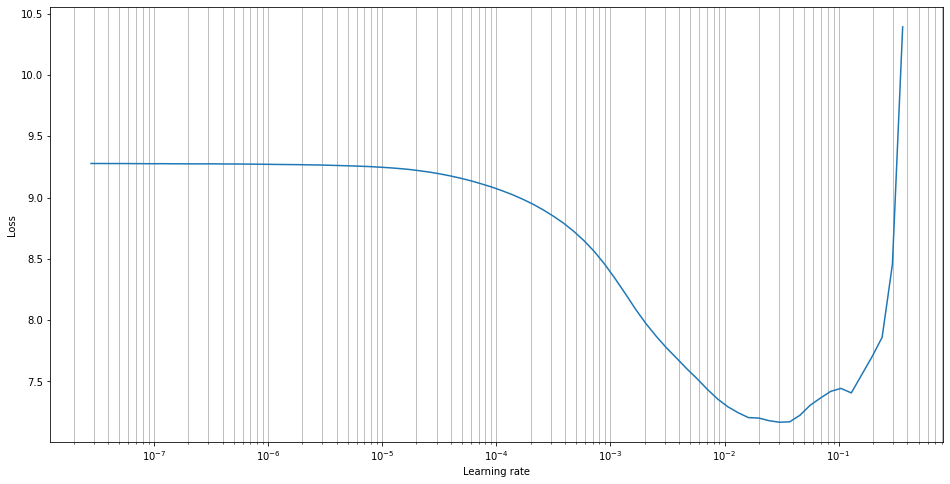

In [ ]:
plot_lr_finder(lrs, losses)

К энкодеру и декодеру применяются несколько отличающиеся lr. Обе части модели обучаются с нуля, нас интересует проблема затухающего градиента. Чем дальше слои от выхода модели, тем она более ярко выражена, поэтому у энкодера выше lr.

В discriminative fine-tuning все наоборот: у энкодера lr меньше, чем у декодера, но это не наш случай. Там это делается из-за того, что более глубокие слои модели уже умеют хорошо извлекать признаки и мы не хотим эти слои слишком сильно менять.

In [ ]:
FOUND_LR = 1e-3

optimizer = optim.AdamW([{"params": model.encoder.parameters(), "lr": 1.3*FOUND_LR},
                         {"params": model.decoder.parameters(), "lr": 0.7*FOUND_LR}],
                        lr=FOUND_LR)

Фиксированный lr будет у оптимизатора только первые 5 эпох. Далее будет применяться CosineAnnealing-стратегия. Пример ниже демонстрирует, как именно будет изменяться learning_rate при итерировании по батчам.

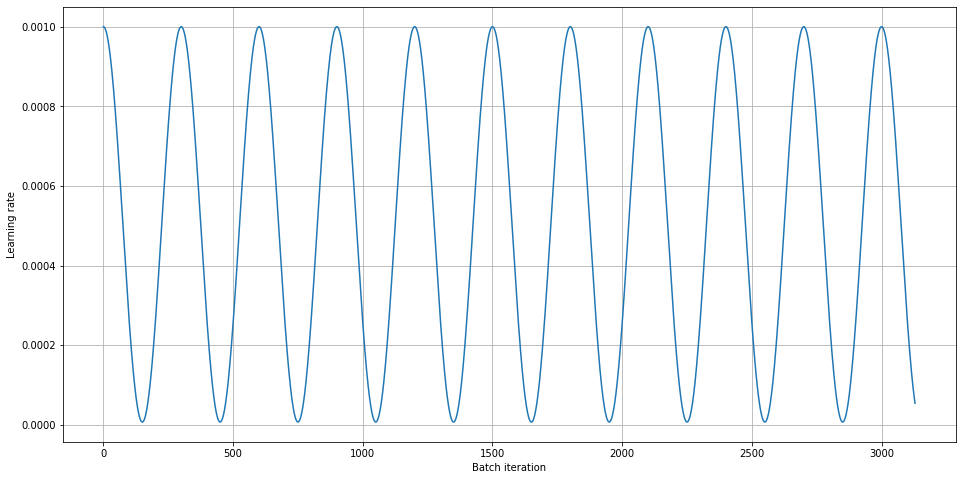

In [ ]:
toy_model = torch.nn.Linear(2, 1)
toy_optimizer = optim.SGD(toy_model.parameters(), lr=FOUND_LR)

toy_lr_sched_CALR = optim.lr_scheduler.CosineAnnealingLR(toy_optimizer,
                                                         T_max=150,
                                                         eta_min=7e-6,
                                                         last_epoch=-1)


lrs = []
for epoch in range(10):
    for i in range(313):
        toy_optimizer.step()
        lrs.append(
            toy_optimizer.param_groups[0]["lr"]
        )
        toy_lr_sched_CALR.step()
    

plt.figure(figsize=(16, 8))
plt.plot(lrs)
plt.ylabel("Learning rate")
plt.xlabel("Batch iteration")
plt.grid()
plt.show()

#### Функции обучения

Стандартный цикл обучения, адаптированный под нашу модель. Дополнительно выходит графики лосса на трейне и валидации, причем в нескольких вариантах, чтобы была ясна как локальная, так и глобальная картина сходимости.

В отличие от двух других подходов, где применялся [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau) здесь используется [CosineAnnealinLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR). Мы больше не следим за изменением лосса на валидации, а периодически меняем его вслепую, как показано на примере выше. Поэтому scheduler перенесен в train() и step() присходит после каждой итерации, а не эпохи.

In [ ]:
def train(model, iterator, optimizer, criterion, clip, scheduler=None,
          train_history=None, valid_history=None, verbose_train_history=None):
    
    model.train()
    
    epoch_loss = 0
    history = list()
    for i, batch in enumerate(iterator):
        
        # src = [batch size, src len]
        # trg = [batch size, trg len]
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        # output = [batch size, trg len - 1, output dim]
        output = model(src, trg[:, :-1])
            
        output_dim = output.shape[-1]
        
        # output = [batch size * (trg len - 1), output dim]
        # trg = [batch size * (trg len - 1)]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()

        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())

        if scheduler is not None:
            scheduler.step()

        if (i+1)%10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

            clear_output(True)
            ax[0].plot(history, label="train")
            ax[0].set_xlabel('Batch')
            ax[0].set_ylabel('Loss')
            ax[0].set_title('Train loss on current epoch')
            ax[0].grid(which='major', color='#DDDDDD', linewidth=0.8)
            ax[0].legend()
            if train_history is not None:
                ax[1].plot(train_history, label='train')
                ax[1].set_xlabel('Epoch')
                ax[1].set_ylabel('Loss')
                ax[1].set_title('General loss history')
                ax[1].grid(which='major', color='#DDDDDD', linewidth=0.8)
            if valid_history is not None:
                ax[1].plot(valid_history, label='validation')
                ax[1].legend()
            if verbose_train_history is not None:
                ax[2].plot(verbose_train_history, label="train")
                ax[2].set_xlabel('Batch iteration')
                ax[2].set_ylabel('Loss')
                ax[2].set_title('Verbose train history')
                ax[2].grid(which='major', color='#DDDDDD', linewidth=0.8)
                ax[2].legend()
            
            plt.show()
        
    return epoch_loss / len(iterator), history

Функция для validation и test стадий. Повторяет train, но без вычисления градиентов и шагов оптимизатора и планировщика.

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            
            # src = [batch size, src len]
            # trg = [batch size, trg len]
            src= batch.src
            trg = batch.trg

            # output = [batch size, trg len - 1, output dim]
            output = model(src, trg[:, :-1])

            # output = [batch size * (trg len - 1), output dim]
            # trg = [batch size * (trg len - 1)]
            output = output.contiguous().view(-1, output.shape[-1])
            trg = trg[:, 1:].contiguous().view(-1)
            
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Обучение

Подключим гугл-диск для сохранения истории обучения и весов модели.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
lr_sched_CALR = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=150,
    eta_min=7e-6,
    last_epoch=-1
)

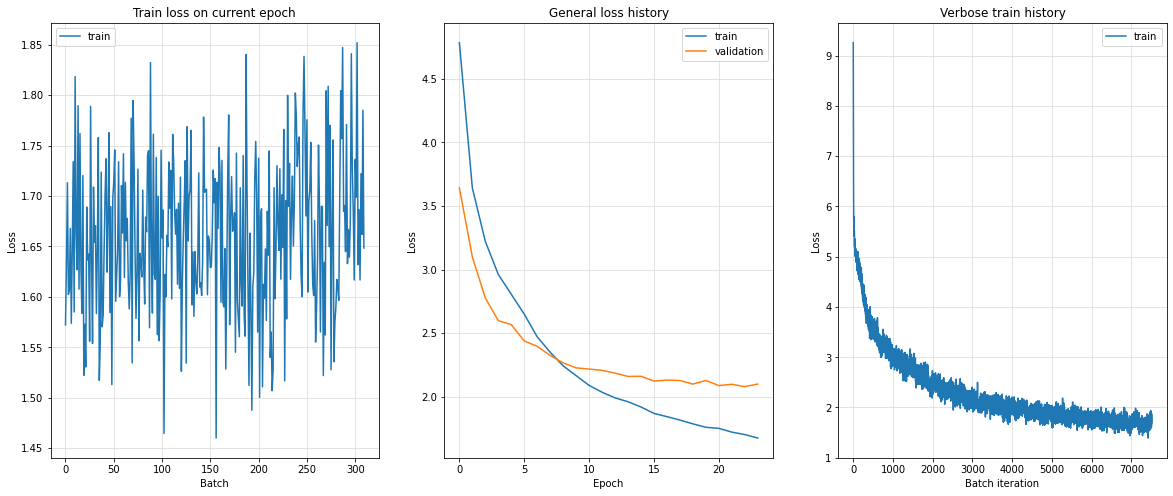

Epoch: 25 | Time: 9m 12s
	Train Loss: 1.660 | Train PPL:   5.261
	 Val. Loss: 2.065 |  Val. PPL:   7.886


In [ ]:
train_history = []
valid_history = []
verbose_train_history = []

N_EPOCHS = 25
CLIP = 1
model_save_path = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/CNN-Transformer.pt'
history_save_path = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/CNN-Transformer_history.json'

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    # check if lr_scheduler should be activated
    if epoch < 5:
        sched = None
    else:
        sched = lr_sched_CALR
    
    start_time = time.time()

    train_loss, history = train(model, train_iterator, optimizer,
                                criterion, CLIP, sched,
                                train_history=train_history,
                                valid_history=valid_history,
                                verbose_train_history=verbose_train_history)
    
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss <= best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    verbose_train_history.extend(history)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


verbose_train_history = [x.item() for x in verbose_train_history]
whole_history = {
    "train_history": train_history,
    "valid_history": valid_history,
    "verbose_train_history": verbose_train_history
}

with open(history_save_path, "w") as history_file:
    json.dump(whole_history, history_file)

Обучение имело бы смысл продолжить и дальше, но остальные модели обучались около 20 эпох, поэтому для чистоты эксперимента остановимся здесь.

Загружаем лучшую на валидации модель и проверяем качество на тесте.

In [ ]:
model_save_path = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/CNN-Transformer.pt'
model.load_state_dict(torch.load(model_save_path))

start_time = time.time()
test_loss = evaluate(model, test_iterator, criterion)
end_time = time.time()

eval_mins, eval_secs = epoch_time(start_time, end_time)
print(f'Test evaluation time: {eval_mins}m {eval_secs}s')

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

Test evaluation time: 0m 12s
| Test Loss: 2.069 | Test PPL:   7.918 |


### Результаты

#### Примеры перевода

Для вывода читаемых переводов используется код из baseline-решения с некоторыми доработками.

In [ ]:
# знаки пунктуации, пищущиеся со словами слитно
punct_signs = ['.', '.\n', ',', ',\n', '?', '?\n', '!', '!\n', '»', '»\n',
               ';', ';\n', '«']


def unsplit_punct(sentence):
    changed_sent = list()
    for word in sentence.split(" "):
        if word in punct_signs[:-1] and len(changed_sent) > 0:
            changed_sent[-1] += word
        elif len(changed_sent) > 0 and changed_sent[-1] == punct_signs[-1]:
            changed_sent[-1] += word
        else:
            changed_sent.append(word)
        
    return " ".join(changed_sent)


def flatten(l):
    return [item for sublist in l for item in sublist]


def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, curr_vocab):
    text = [curr_vocab.itos[token] for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text


def generate_translation(src, trg, model, TRG_vocab, SRC_vocab):
    model.eval()

    # turn off teacher forcing
    with torch.no_grad():
        output = model(src, trg[:, :-1])

    output = output.argmax(dim=-1).cpu().numpy()

    source = get_text(list(src[0, :].cpu().numpy()), SRC_vocab)
    original = get_text(list(trg[0, 1:].cpu().numpy()), TRG_vocab)
    generated = get_text(list(output[0, :]), TRG_vocab)

    source = unsplit_punct(' '.join(source))
    original = unsplit_punct(' '.join(original))
    generated = unsplit_punct(' '.join(generated))
    
    print('Source: {}'.format(source))
    print('Original: {}'.format(original))
    print('Generated: {}'.format(generated))
    print()

In [ ]:
batch = next(iter(train_iterator))
print("Example from train data:")
for idx in [1, 2]:
    src = batch.src[idx:idx+1, :]
    trg = batch.trg[idx:idx+1, :]
    generate_translation(src, trg, model, TRG.vocab, SRC.vocab)

Example from train data:
Source: в некоторых номерах мотеля europa установлен кондиционер, тогда как в других номерах есть собственный балкон. при этом все номера располагают бесплатным wi - fi, кабельным телевидением и мини - баром.
Original: some rooms at motel europa feature air - conditioning and some have a private balcony, while they are all equipped with free wi - fi, cable tv and a minibar.
Generated: some rooms at the at at air - conditioned and some rooms a private balcony, equipped cable with equipped rooms with free wi - fi. cable tv. minibar minibar.

Source: отель benidorm находится в 5 минутах ходьбы от многочисленных тапас - баров, кафе и магазинов.
Original: benidorm are within 5 minutes ’ walk of many tapas bars, cafés and shops.
Generated: benidorm benidorm is a a minutes ’ walk from tapas tapas bars bars cafes and shops.



Перевод на трейне не идеален, но уловить суть можно. Стоит обратить внимание на то, что модель любит повторять слова. 

In [ ]:
batch = next(iter(valid_iterator))
print("Example from valid data:")
for idx in [1, 2]:
    src = batch.src[idx:idx+1, :]
    trg = batch.trg[idx:idx+1, :]
    generate_translation(src, trg, model, TRG.vocab, SRC.vocab)

Example from valid data:
Source: в гостиной установлен жк - телевизор.
Original: there is also a living room with an lcd tv.
Generated: the is also an tv room with an lcd tv.

Source: предоставляются факсимильные и копировальные услуги.
Original: guests can of fax and photocopying service.
Generated: fax and fax and fax and photocopying services are



In [ ]:
batch = next(iter(test_iterator))
print("Example from test data:")
for idx in [3, 4]:
    src = batch.src[idx:idx+1, :]
    trg = batch.trg[idx:idx+1, :]
    generate_translation(src, trg, model, TRG.vocab, SRC.vocab)

Example from test data:
Source: имеется бесплатная частная парковка.
Original: free private parking is available.
Generated: free private parking is available on

Source: поблизости работает несколько ресторанов.
Original: there are several restaurants in the surrounding area.
Generated: several are several restaurants nearby the vicinity vicinity.



Для теста и валидации можно сделать аналогичные трейну замечания. Еще можно отметить проблемы модели с постановкой точек, чего у других моделей замечено не было.

#### BLEU score

Посчитаем результурующее качество модели.

In [ ]:
import tqdm
from nltk.translate.bleu_score import corpus_bleu


original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        
        # src = [batch size, src len]
        # trg = [batch size, trg len]
        src = batch.src
        trg = batch.trg

        # output = [batch size, trg len - 1, output dim]
        output = model(src, trg[:, :-1])

        output = output.argmax(dim=-1)
        
        curr_batch_size = trg.shape[0]
        for idx in range(curr_batch_size):
            original_text.append(get_text(trg[idx, 1:], TRG.vocab))
            generated_text.append(get_text(output[idx, :], TRG.vocab))

59it [00:19,  3.00it/s]


In [ ]:
corpus_bleu_score = corpus_bleu([[text] for text in original_text], generated_text)

print(f'BLEU score = {corpus_bleu_score*100:.2f}')

BLEU score = 27.88


Несколько лучше решения с LSTM, где было 27.46, но при этом лосс здесь значительно меньше, чем был там. Это говорит о том, что уменьшение кросс-энтропии не эквивалентно пропорциональному улучшению BLEU и качества перевода.